## <center> Итоговый проект: Модель прогнозирования стоимости жилья для агентства недвижимости

## 1. Постановка задачи

Агентство недвижимости столкнулось с проблемой — риелторы тратят слишком много времени на сортировку объявлений и поиск выгодных предложений. Поэтому скорость их реакции и качество анализа не дотягивают до уровня конкурентов. Это сказывается на финансовых показателях агентства.

**Задача:** разработать модель, которая позволила бы агентству недвижимости обойти конкурентов по скорости и качеству совершения сделок.

**Основные цели проекта:**
1. Провести разведывательный анализ и очистку исходных данных.
2. Выделить наиболее значимые факторы, влияющие на стоимость недвижимости.
3. Построить модель для прогнозирования стоимости недвижимости.
4. Разработать небольшой веб-сервис, на вход которому поступают данные о некоторой выставленной на продажу недвижимости, а сервис прогнозирует его стоимость.

## 2. Знакомство с данными и базовый анализ

In [1]:
#импорт библиотек и модулей

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import category_encoders as ce # для бинарного кодирования

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model #линейные модели
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing #предобработка
import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

In [2]:
# прочитаем файл с исходными данными и выведем его размерность

df = pd.read_csv('data.csv')

display('Shape of data: {}'.format(df.shape))

df.head()

'Shape of data: (377185, 18)'

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [3]:
# сделаем копию для дальнейшей работы

data = df.copy()

display('Shape of data: {}'.format(data.shape))

data.info()

'Shape of data: (377185, 18)'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

Пропуски в данных

In [4]:
# выведем долю пропусков в столбцах
    
(data.isnull().mean()*100).sort_values(ascending=False)

private pool    98.891525
mls-id          93.387330
PrivatePool     89.312672
fireplace       72.662221
stories         39.958111
baths           28.192532
beds            24.200856
MlsId           17.731352
sqft            10.757851
status          10.583136
propertyType     9.208479
target           0.657767
city             0.009014
street           0.000530
zipcode          0.000000
schools          0.000000
state            0.000000
homeFacts        0.000000
dtype: float64

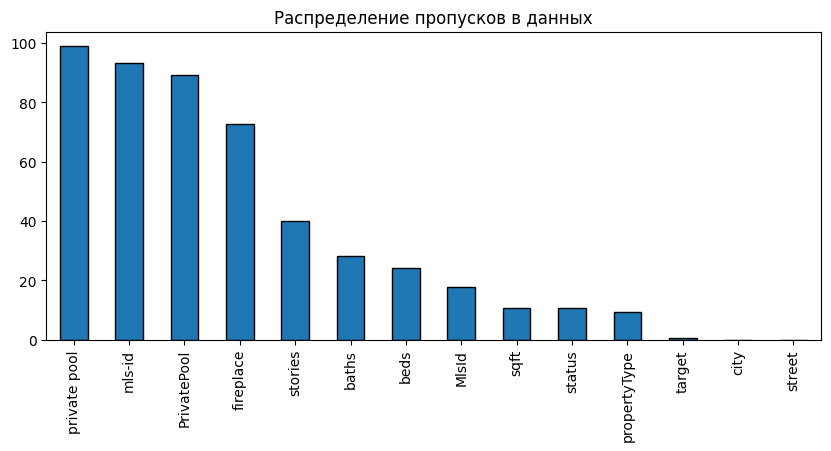

In [5]:
# построим дополнительно столбчатую диаграмму пропусков

cols_null_persent = data.isnull().mean() * 100
null_cols = cols_null_persent[cols_null_persent>0].sort_values(ascending=False)

null_cols.plot(
    kind='bar',
    figsize=(10, 4),
    title='Распределение пропусков в данных'
);

5 столбцов имеют более 39% пропусков:

* private pool    98.89%

* mls-id          93.39%

* PrivatePool     89.31%

* fireplace       72.66%

* stories         39.96%

Удалим эти признаки. Также удалим столбец MlsId как служебную информацию.

In [6]:
data = data.drop(['private pool', 'mls-id', 'PrivatePool', 'fireplace', 'stories', 'MlsId'], axis=1)

display(data.shape)

(377185, 12)

В целевом признаке target также есть пропуски (0.66%). Удалим такие строки.

In [7]:
data = data.dropna(subset=['target']).reset_index(drop=True)

In [8]:
display('Shape of data: {}'.format(data.shape))

data.info()

'Shape of data: (374704, 12)'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374704 entries, 0 to 374703
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        335447 non-null  object
 1   propertyType  340150 non-null  object
 2   street        374702 non-null  object
 3   baths         269328 non-null  object
 4   homeFacts     374704 non-null  object
 5   city          374670 non-null  object
 6   schools       374704 non-null  object
 7   sqft          334582 non-null  object
 8   zipcode       374704 non-null  object
 9   beds          283748 non-null  object
 10  state         374704 non-null  object
 11  target        374704 non-null  object
dtypes: object(12)
memory usage: 34.3+ MB


Посмотрим пропуски в строках

In [9]:
display(data.isnull().sum(axis=1).sort_values(ascending=False))

display(data[data.isnull().sum(axis=1)>=4])

data.iloc[[115267]]

50886     4
339191    4
255106    4
255104    4
143860    4
         ..
217424    0
217425    0
217426    0
217427    0
0         0
Length: 374704, dtype: int64

,status,propertyType,street,baths,homeFacts,city,schools,sqft,zipcode,beds,state,target
7,Active,NaN,6094 Mingle Dr,NaN,"{'atAGlanceFacts': [{'factValue': '1976', 'fac...",Memphis,"[{'rating': ['4', '2', '2'], 'data': {'Distanc...",NaN,38115,NaN,TN,"68,000"
40,Active,NaN,1104 Rotonda Cir,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",ROTONDA WEST,"[{'rating': ['6', '6', '7'], 'data': {'Distanc...",NaN,33947,NaN,FL,"54,000"
42,Active,NaN,MLS #: STRI1057289,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",New York,"[{'rating': ['NR', 'NR', '9', '8', '8', '2', '...",NaN,10006,NaN,NY,"850,000"
48,Active,NaN,18b Sitton-Mills Pl,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",Signal Mountain,"[{'rating': ['8', 'NR', '7', '4'], 'data': {'D...",NaN,37377,NaN,TN,"125,000"
63,Active,NaN,107 Road 5110,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",Cleveland,"[{'rating': ['NR', '4', '6', '5', '2'], 'data'...",NaN,77327,NaN,TX,"50,000"
...,...,...,...,...,...,...,...,...,...,...,...,...
374624,Active,NaN,12031 Cassino Ave,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",PORT CHARLOTTE,"[{'rating': ['5', '4', '6'], 'data': {'Distanc...",NaN,33953,NaN,FL,"15,000"
374637,Active,NaN,2889 SW 35th Ave,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",Miami,"[{'rating': ['7', 'NR', '10', '5', '5'], 'data...",NaN,33133,NaN,FL,"639,000"
374660,Active,NaN,Mantova Ct,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",ORLANDO,"[{'rating': ['7', '6', 'NR', 'NR', '7'], 'data...",NaN,32836,NaN,FL,"400,000"
374673,Active,NaN,2104 Russell Ave,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",Charlotte,"[{'rating': ['2', '3', '3'], 'data': {'Distanc...",NaN,28216,NaN,NC,"99,990"


,status,propertyType,street,baths,homeFacts,city,schools,sqft,zipcode,beds,state,target
115267,NaN,NaN,6815 Westover St,NaN,"{'atAGlanceFacts': [{'factValue': None, 'factL...",Houston,"[{'rating': ['5/10', '5/10', '2/10'], 'data': ...",NaN,77087,0.36 acres,TX,"$110,000"


In [10]:
# удаляем строки с 4 пропусками
m = data.shape[1] #число признаков в данных
data = data.dropna(thresh=m-3, axis=0)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 358608 entries, 0 to 374703
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        322292 non-null  object
 1   propertyType  340148 non-null  object
 2   street        358607 non-null  object
 3   baths         269328 non-null  object
 4   homeFacts     358608 non-null  object
 5   city          358575 non-null  object
 6   schools       358608 non-null  object
 7   sqft          334571 non-null  object
 8   zipcode       358608 non-null  object
 9   beds          280818 non-null  object
 10  state         358608 non-null  object
 11  target        358608 non-null  object
dtypes: object(12)
memory usage: 35.6+ MB


In [11]:
# посмотрим на количество уникальных значений в признаке street
data['street'].nunique()

319933

In [12]:
# удалим признак из-за большого количества уникальных значений
data = data.drop(['street'], axis=1)

In [13]:
# удалим строки со значением в propertyType 'land' и 'lot/land', так как это земля, использовать ее для прогноза стоимости жилья не будем

data['propertyType'] = data['propertyType'].str.lower() #приведем строки в стобце к нижненму регистру
data = data[(data.propertyType != 'land') & (data.propertyType != 'lot/land')]

data.shape

(327145, 11)

Проверим наличие дубликатов

In [14]:
display('Number of duplicates: {}'.format(data.duplicated().sum()))

'Number of duplicates: 1611'

In [15]:
# удалим дубликаты
data = data.drop_duplicates().reset_index(drop=True)

display('Shape of data: {}'.format(data.shape))

'Shape of data: (325534, 11)'

In [16]:
(data.isnull().mean()*100).sort_values(ascending=False)

baths           18.990950
beds            14.938532
status          11.057217
propertyType     5.611088
sqft             2.309436
city             0.002765
homeFacts        0.000000
schools          0.000000
zipcode          0.000000
state            0.000000
target           0.000000
dtype: float64

Из данных удалено 51 651 наблюдений, или 13,7% от первоначального количества.

In [17]:
# посмотрим на пропуски в городах 

display(data[data['city'].isnull()])

,status,propertyType,baths,homeFacts,city,schools,sqft,zipcode,beds,state,target
6799,Active,single family home,2,"{'atAGlanceFacts': [{'factValue': '2000', 'fac...",NaN,"[{'rating': ['1', '4', '3', '3', '6', '6'], 'd...",1016,32686,1,FL,"$1,495,000"
113025,For sale,single family,Bathrooms: 6,"{'atAGlanceFacts': [{'factValue': '2000', 'fac...",NaN,"[{'rating': ['5/10', 'NA', '4/10'], 'data': {'...","Total interior livable area: 5,905 sqft",20003,5 bd,MA,"$1,650,000"
147360,Active,single family home,7.5,"{'atAGlanceFacts': [{'factValue': '2015', 'fac...",NaN,"[{'rating': ['2', '4', '6', '4', '3', '10', 'N...",0,34741,7,FL,"$675,000"
240676,Active,single family home,5.5,"{'atAGlanceFacts': [{'factValue': '2016', 'fac...",NaN,"[{'rating': ['4', '9', '6', '5', '3', 'NR', 'N...",0,34747,9,FL,"$595,000"
243675,Active,single family home,9,"{'atAGlanceFacts': [{'factValue': '2018', 'fac...",NaN,"[{'rating': ['4', '3', '6', '5', '9', 'NR', 'N...",5141,34747,10,FL,"$890,000"
267045,Active,condo/townhome/row home/co-op,2,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,34747,2,FL,"$343,300"
298913,For sale,single family,Bathrooms: 4,"{'atAGlanceFacts': [{'factValue': '1991', 'fac...",NaN,"[{'rating': ['10/10', '3/10'], 'data': {'Dista...",-- sqft,33126,6 bd,FL,"$340,000"
309840,Active,single family home,7,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,34747,7,FL,"$1,012,600"
319404,Active,farms/ranches,0,"{'atAGlanceFacts': [{'factValue': '1982', 'fac...",NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",30000,77032,10.0,TX,"$2,700,000"


In [18]:
# отсортируем данные по индексу (zipcode) и заполним пропуски в столбце city следующим по порядку значением

data = data.sort_values(by='zipcode')

data['city'] = data['city'].fillna(method='ffill')

In [19]:
# вернем сортировку по инексу

data = data.sort_index()

data.head()

,status,propertyType,baths,homeFacts,city,schools,sqft,zipcode,beds,state,target
0,Active,single family home,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,"$418,000"
1,for sale,single-family home,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,"$310,000"
2,for sale,single-family home,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,"$2,895,000"
3,for sale,single-family home,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,"$2,395,000"
4,for sale,townhouse,NaN,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",Philadelphia,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897 sqft,19145,2 Beds,PA,"$209,000"


Преобразуем столбец с целевой переменной target из типа object в числовой. Отметим, что стоимость недвижимости указана в виде строки со следующими особенностями: 

*  в начале записи есть знак '$'
*  каждые три разряда разделены запятой
*  последним знаком в некторых записях является +
*  для недвижимости со статусом 'for rent' указана стоимость аренды в месяц. В конце строки присутствуют символы '/mo'
*  есть 1 строка с диапазоном цен '$1,215 - $1,437/mo'

In [20]:
# пример описанных выше записей

display(data.iloc[[42]])
display(data.iloc[[478]])
display(data.iloc[[285333]])

,status,propertyType,baths,homeFacts,city,schools,sqft,zipcode,beds,state,target
42,for sale,single-family home,2 Baths,"{'atAGlanceFacts': [{'factValue': '2017', 'fac...",Fort Worth,"[{'rating': ['7/10', '6/10', '8/10'], 'data': ...","1,683 sqft",76179,3 Beds,TX,"$233,990+"


,status,propertyType,baths,homeFacts,city,schools,sqft,zipcode,beds,state,target
478,for rent,single-family home,3.5 Baths,"{'atAGlanceFacts': [{'factValue': '1913', 'fac...",Chicago,"[{'rating': ['1/10', '4/10', '2/10', 'None/10'...","3,300 sqft",60618,4 Beds,IL,"$5,500/mo"


,status,propertyType,baths,homeFacts,city,schools,sqft,zipcode,beds,state,target
285333,for rent,apartment,1-2 Baths,"{'atAGlanceFacts': [{'factValue': '1964', 'fac...",Dallas,"[{'rating': ['5/10', '5/10', '5/10'], 'data': ...",610-840 sqft,75206,1-2 Beds,TX,"$1,215 - $1,437/mo"


In [21]:
# обработаем столбец с целевой переменной, преобразуем его в числовой тип

data['target'] = data['target'].apply(lambda x: x.strip('$ + /mo').split(','))
data['target'] = data['target'].apply(lambda x: ''.join(x))
data.loc[data['target']=='1215 - $1437', ['target']]=1326 # заполним значение, заданное диапазоном, средним
data['target'] = data['target'].astype(float)

data.head()

,status,propertyType,baths,homeFacts,city,schools,sqft,zipcode,beds,state,target
0,Active,single family home,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,418000.0
1,for sale,single-family home,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,310000.0
2,for sale,single-family home,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,2895000.0
3,for sale,single-family home,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,2395000.0
4,for sale,townhouse,NaN,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",Philadelphia,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897 sqft,19145,2 Beds,PA,209000.0


In [22]:
# посмотрим на минимальное и максимальное значение стоимости

display(data['target'].min())
display(data['target'].max())

data.describe()

1.0

195000000.0

,target
count,3.255340e+05
mean,6.527900e+05
std,1.795924e+06
min,1.000000e+00
25%,2.149000e+05
50%,3.399000e+05
75%,5.980000e+05
max,1.950000e+08


In [23]:
display(data[data['target']==1])

display(data[data['target']==195000000.0])

display(data[data['target']==3])

display(data[data['target']==165000000.0])

,status,propertyType,baths,homeFacts,city,schools,sqft,zipcode,beds,state,target
13550,Active,single family home,2,"{'atAGlanceFacts': [{'factValue': '1940', 'fac...",Goodlettsville,"[{'rating': ['3', '2', '3', '3', '2', '1', 'NR...",1596,37072,3.0,TN,1.0
22065,NaN,single family,1.0,"{'atAGlanceFacts': [{'factValue': '1957', 'fac...",Indianapolis,"[{'rating': ['2/10', 'NA', '1/10'], 'data': {'...","1,586",46224,3,IN,1.0
218423,Active,2 story,NaN,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",Circleville,"[{'rating': ['4', 'NR', '5', '5'], 'data': {'D...","1,771",43113,NaN,OH,1.0
221507,NaN,condo,3.0,"{'atAGlanceFacts': [{'factValue': '1989', 'fac...",Indianapolis,"[{'rating': ['4/10', '4/10', '3/10'], 'data': ...","1,780",46250,3,IN,1.0
239881,foreclosure,multi-family,3 Baths,"{'atAGlanceFacts': [{'factValue': '1870', 'fac...",Cincinnati,"[{'rating': ['4/10', '2/10', '1/10', '1/10', '...","3,226 sqft",45225,3 Beds,OH,1.0
249732,Active,NaN,"1,750","{'atAGlanceFacts': [{'factValue': '', 'factLab...",Huntley,"[{'rating': [], 'data': {'Distance': [], 'Grad...",NaN,60142,Baths,IL,1.0
249818,foreclosure,single-family home,2 Baths,"{'atAGlanceFacts': [{'factValue': '1940', 'fac...",Goodlettsville,"[{'rating': ['3/10', '2/10', '3/10'], 'data': ...","1,596 sqft",37072,3 Beds,TN,1.0
262585,foreclosure,single-family home,NaN,"{'atAGlanceFacts': [{'factValue': '1957', 'fac...",Indianapolis,"[{'rating': ['2/10'], 'data': {'Distance': ['0...","1,586 sqft",46224,3 Beds,IN,1.0
277609,foreclosure,condo,3 Baths,"{'atAGlanceFacts': [{'factValue': '1989', 'fac...",Indianapolis,"[{'rating': ['4/10', '3/10', '4/10'], 'data': ...","1,780 sqft",46250,3 Beds,IN,1.0


,status,propertyType,baths,homeFacts,city,schools,sqft,zipcode,beds,state,target
114628,For sale,single family,18.0,"{'atAGlanceFacts': [{'factValue': '1935', 'fac...",Los Angeles,"[{'rating': ['10/10', '7/10'], 'data': {'Dista...",--,90077,11,CA,195000000.0


,status,propertyType,baths,homeFacts,city,schools,sqft,zipcode,beds,state,target
153825,Active,NaN,"1,500","{'atAGlanceFacts': [{'factValue': '', 'factLab...",Dania Beach,"[{'rating': ['4', '4', '3'], 'data': {'Distanc...",NaN,33312,Baths,FL,3.0


,status,propertyType,baths,homeFacts,city,schools,sqft,zipcode,beds,state,target
124218,for sale,single-family home,23 Baths,"{'atAGlanceFacts': [{'factValue': '1998', 'fac...",Beverly Hills,"[{'rating': ['7/10', '5/10', '10/10'], 'data':...","28,660 sqft",90210,20 Beds,CA,165000000.0
247122,For sale,single family,23.0,"{'atAGlanceFacts': [{'factValue': '1998', 'fac...",Beverly Hills,"[{'rating': ['10/10', '5/10', '7/10'], 'data':...","28,660",90210,20,CA,165000000.0


Для перечня недвижимости по цене 1$, 3$, 29$, 393$ и 195000000$ проверим наличие информации о стоимости за 1 sqft в признаке homeFacts. Если она есть, заполним соответствующим значением.

In [24]:
#data['homeFacts'][277609]

Информации не оказалось, поэтому удалим эти строки. Удалим также строки, где значение целевой переменной 500 и 600$ (3 строки), так как эта недвижимость не для аренды, а значит, цена не соответствует.

In [25]:
data = data[(data.target != 1) & (data.target != 195000000) & (data.target != 3) & (data.target != 29) & (data.target != 393) & (data.target != 500) & (data.target != 600)]

display(data['target'].min())
display(data['target'].max())

data.describe()

700.0

165000000.0

,target
count,3.255160e+05
mean,6.522270e+05
std,1.763368e+06
min,7.000000e+02
25%,2.149000e+05
50%,3.399000e+05
75%,5.980000e+05
max,1.650000e+08


Недвижимость за 700$ предназначена для найма, т.е. цена указана за месяц.
По двум объектам на Беверли Хиллз за 165000000$ видим, что это дубликат - информация об одном и том же объекте недвижимости. Удалим одну из строк. Другую оставим, цена за sqft соответствует.

In [26]:
data = data.drop(index=124218)
data[data['target']==165000000]

,status,propertyType,baths,homeFacts,city,schools,sqft,zipcode,beds,state,target
247122,For sale,single family,23.0,"{'atAGlanceFacts': [{'factValue': '1998', 'fac...",Beverly Hills,"[{'rating': ['10/10', '5/10', '7/10'], 'data':...","28,660",90210,20,CA,165000000.0


Преобразуем в числовой тип столбцы baths, sqft, beds.

In [28]:
# количество уникальных значений в столбце
data['baths'].nunique()

225

In [29]:
# преобразование столбца baths

data['baths'] = data['baths'].str.lower() # переводим текст в нижний регистр

data['baths'] = data['baths'].apply(lambda x: x if x is np.nan else x.strip('+' ' ')) # удаляем значки в начале и конце строк

data['baths'] = data['baths'].apply(lambda x: x if x is np.nan else (x.split(' ')[1] if x.startswith('bath') else x.split(' ')[0])) # выбираем из строки кол-во ванных комнат

data['baths'] = data['baths'].apply(lambda x: x if x is np.nan else x.split(',')[0]) # для значений, разделенных запятой, оставляем первую цифру

data['baths'] = data['baths'].apply(lambda x: x if x is np.nan else x.split('-')[0]) # для значений, разделенных тире, оставляем первую цифру

data['baths'] = data['baths'].apply(lambda x: np.nan if (x=='~' or x=='sq.' or x=='--' or x=='—' or x=='semimod' or x=='') else x) # заменяем на nan значения строк, где не оказалось чисел (по факту это пропуски в данных)

data['baths'] = data['baths'].astype(float) # преобразуем столбец к типу float

data['baths'] = data['baths'].apply(np.floor) #округлим до целого дробные значения количества ванных комнат

display(data.head())
data['baths'].nunique()


,status,propertyType,baths,homeFacts,city,schools,sqft,zipcode,beds,state,target
0,Active,single family home,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,418000.0
1,for sale,single-family home,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,310000.0
2,for sale,single-family home,2.0,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,2895000.0
3,for sale,single-family home,8.0,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,2395000.0
4,for sale,townhouse,NaN,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",Philadelphia,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897 sqft,19145,2 Beds,PA,209000.0


49

In [30]:
#посмотрим на значения в столбце baths

data['baths'].value_counts()

baths
2.0      118103
3.0       72028
4.0       27584
1.0       24766
5.0        9931
6.0        4475
7.0        2152
8.0        1185
9.0         550
10.0        341
750.0       237
0.0         198
11.0        189
12.0        137
13.0         74
16.0         52
14.0         46
18.0         31
15.0         28
24.0         17
20.0         15
22.0         10
17.0         10
26.0          8
23.0          7
30.0          6
27.0          5
40.0          4
21.0          4
36.0          3
44.0          3
19.0          3
32.0          3
29.0          2
34.0          2
28.0          2
60.0          1
39.0          1
64.0          1
42.0          1
43.0          1
41.0          1
25.0          1
55.0          1
241.0         1
76.0          1
116.0         1
35.0          1
68.0          1
Name: count, dtype: int64

Видим, что есть количество 0, 116, 241, 750. 
* Нули заменим на nan, т.к. это пропуски.
* Проверим объекты со 116, 241 и 750 ванными комнатами

Дом со 116 ванными комнатами многоквартирный, площадь и стоимость соответствуют заполненным данным.

Дом с 241 ванной предназначен для одной семьи, считаем ошибкой, заполняем nan

В объектах с 750 ванными явно какая-то путаница, так как во многих строках признак beds заполнен словом baths. Однако площадь и цена на первый взгляд заполнены корректно, поэтому удалять строки не будем, а заполним значениями nan

In [31]:
data.loc[(data['baths']==0) | (data['baths']==750) | (data['baths']==241), ['baths']] = np.nan

In [32]:
# преобразуем площадь

data['sqft'].nunique() # количество уникальных значений

24898

In [33]:
# вспомогательный код для проверки отдельных значений

# data[data['sqft'].str.contains('610-840', na=False)]

In [34]:

data['sqft'] = data['sqft'].apply(lambda x: x if x is np.nan else (x.split(' ')[-2] if len(x.split(' '))>=2 else x.split(' ')[0]))

data['sqft'] = data['sqft'].apply(lambda x: x if x is np.nan else x.split(','))
data['sqft'] = data['sqft'].apply(lambda x: x if x is np.nan else ''.join(x))

data['sqft'] = data['sqft'].apply(lambda x: np.nan if (x=='--') else x) # заменяем на nan значения строк, где не оказалось чисел (по факту это пропуски в данных)
data.loc[data['sqft']=='610-840', ['sqft']]=725 # заполним значение, заданное диапазоном, средним

data['sqft'] = data['sqft'].astype(float) # преобразуем столбец к типу float

data['sqft'].nunique()

9480

У самого дорогого объекта недвижимости площадь составляет 28660 sqft, также много объектов, где площадь очень мала.

Удалим объекты, где площадь меньше 100 и больше 28660 sqft

Заметим, что для недвижимости с типом coop (квартира в жилищном кооперативе) прослеживается несоответствие площади и стоимости жилья. Возможно, для части позиций указана площадь всего кооператива, а стоимость конкретной квартиры.

In [35]:
# чтобы посмотреть инфо по квартирам coop

#data[(data['propertyType'].str.contains('coop', na=False))]

In [36]:
data = data[(data.sqft >= 100) & (data.sqft <= 28660)]

data.describe()

,baths,sqft,target
count,256654.000000,315088.000000,3.150880e+05
mean,2.702853,2189.806245,6.383304e+05
std,1.396610,1512.986531,1.593972e+06
min,1.000000,100.000000,7.000000e+02
25%,2.000000,1300.000000,2.150000e+05
50%,2.000000,1839.000000,3.399000e+05
75%,3.000000,2614.000000,5.950000e+05
max,60.000000,28660.000000,1.650000e+08


In [37]:
(data.isnull().mean()*100).sort_values(ascending=False)

baths           18.545295
beds            14.560377
status          11.282562
propertyType     5.205847
homeFacts        0.000000
city             0.000000
schools          0.000000
sqft             0.000000
zipcode          0.000000
state            0.000000
target           0.000000
dtype: float64

In [38]:
# преобразуем количество спален

data['beds'].nunique() # количество уникальных значений

133

In [39]:
data['beds'] = data['beds'].apply(lambda x: x if x is np.nan else (np.nan if (x.__contains__('acre') or x.__contains__('sqft') or x.__contains__('Bath')) else x.split(' ')[0])) 

data['beds'] = data['beds'].apply(lambda x: np.nan if (x=='--' or x=='' or x=='Based' or x=='#') else x) # заменяем на nan значения строк, где не оказалось чисел (по факту это пропуски в данных)

data['beds'] = data['beds'].apply(lambda x: x if x is np.nan else x.split('-')[0]) # для значений, разделенных тире, оставляем первую цифру

data['beds'] = data['beds'].astype(float) # преобразуем столбец к типу float

display(data['beds'].nunique())

data.info()

45

<class 'pandas.core.frame.DataFrame'>
Index: 315088 entries, 0 to 325533
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        279538 non-null  object 
 1   propertyType  298685 non-null  object 
 2   baths         256654 non-null  float64
 3   homeFacts     315088 non-null  object 
 4   city          315088 non-null  object 
 5   schools       315088 non-null  object 
 6   sqft          315088 non-null  float64
 7   zipcode       315088 non-null  object 
 8   beds          254509 non-null  float64
 9   state         315088 non-null  object 
 10  target        315088 non-null  float64
dtypes: float64(4), object(7)
memory usage: 28.8+ MB


In [40]:
(data.isnull().mean()*100).sort_values(ascending=False)

beds            19.226057
baths           18.545295
status          11.282562
propertyType     5.205847
homeFacts        0.000000
city             0.000000
schools          0.000000
sqft             0.000000
zipcode          0.000000
state            0.000000
target           0.000000
dtype: float64

In [41]:
# заполним пропуски в столбцах status значениями other

data['status'] = data['status'].fillna('other')

data['status'] = data['status'].str.lower() #переведем записи в нижний регистр

display(data['status'].nunique()) #количество уникальных значений
data['status'].unique()

144

array(['active', 'for sale', 'other', 'new construction', 'pending', 'p',
       ' / auction', 'under contract', 'under contract   showing',
       'pre-foreclosure', 'under contract backups',
       'active under contract', 'foreclosure', 'option pending',
       'pre-foreclosure / auction', 'under contract show', 'for rent',
       'auction', 'a active', 'contingent', 'pending   continue to show',
       'foreclosed', 'price change', 'back on market', 'new',
       'active option', 'coming soon: nov 21.',
       'contingent finance and inspection', 'coming soon: dec 4.',
       'p pending sale', 'coming soon: nov 23.',
       'active with contingencies', 'contingent show', 'contract p',
       'contingent take backup', 'apartment for rent', 'backup contract',
       'option contract', 'pending continue to show',
       'pending inspection', 'active option contract', 'c',
       'contingent   show', 'pi', 'contract contingent on buyer sale',
       'u under contract', 'coming soon: no

In [42]:
data['status'] = data['status'].apply(lambda x: 'coming soon' if x.__contains__('coming soon') else x) # заменим значения, где встречается coming soon

# создадим словарь для замены определяемых значений

dict1 = {'foreclosed':'foreclosure',
         'pre foreclosure auction':'pre foreclosure',
         'pre-foreclosure / auction':'pre foreclosure',
         'pre-foreclosure':'pre foreclosure',
         'under contract show':'under contract showing',
         'under contract - show':'under contract showing',
         'uc continue to show':'under contract showing',
         'u under contract':'under contract showing',
         'under contract':'under contract showing',
         'under contract   showing':'under contract showing',
         'active under contract':'under contract showing',
         'active backup':'under contract backups',
         'backup contract':'under contract backups',
         'backup':'under contract backups',
         'under contract taking back up offers':'under contract backups',
         'under contract w/ bckp':'under contract backups',
         'active auction':'auction',
         'auction active':'auction',
         'auction - active':'auction',
         'active - auction':'auction',
         'a active':'auction',
         ' / auction':'auction',
         'active':'activated',
         'for sale':'activated',
         'back on market':'activated',
         're activated':'activated',
         'contingent   show':'activated',
         'contingent show':'activated',
         'active/contingent':'activated',
         'new construction':'new',
         'pending sh':'pending continue show',
         'pending continue to show':'pending continue show', 
         'active with contingencies':'active contingency',
         'contingent':'contingency',
         'price change':'contingency',
         'contingent finance and inspection':'contingency',
         'contract contingent on buyer sale':'contingency contract',
         'c':'contingency',
         'contingency 48 hr (+/ )':'contingency',              
         'p':'pending',
         'option pending':'pending',
         'offer pending signature':'pending',
         'pi':'pending inspection',
         'pending in':'pending inspection',
         'pending w/insp finance':'pending inspection',
         'pending with contingencies':'pending',
         'c continue show':'pending continue show',
         'contract p':'pending',
         'pending - taking backups':'pending take backups',
         'contingent take backup':'pending take backups',
         'pending taking backups':'pending take backups',
         'p pending sale':'pending',
         'apartment for rent':'for rent',
         'condo for rent':'for rent'
         }


data['status'] = data['status'].replace(dict1) # произведем замену в соответствии со словарем

popular_status=data['status'].value_counts().nlargest(10).index # список 20 самых популярных статусов

data['status'] = data['status'].apply(lambda x: x if x in popular_status else 'other') # оставляем значения 10 самых популярных статусов, остальное заменяем на значение other

display(data['status'].value_counts())
display(data['status'].nunique())

status
activated                 251901
other                      36566
foreclosure                 5976
pending                     5904
new                         5823
under contract showing      3152
pre foreclosure             2553
auction                     1572
contingency                 1251
for rent                     390
Name: count, dtype: int64

10

In [43]:
# заполним пропуски в столбцах propertyType значением other

data['propertyType'] = data['propertyType'].fillna('other')

data['propertyType'] = data['propertyType'].str.lower() #переведем записи в нижний регистр

display(data['propertyType'].nunique()) #количество уникальных значений
data['propertyType'].unique()

1235

array(['single family home', 'single-family home', 'townhouse', ...,
       'cabin/lodge, contemporary, converted barn, cottage, loft with bedrooms, log home, post & beam',
       'lake house, single detached, tudor',
       'bilevel, converted dwelling, loft with bedrooms, condo/unit'],
      dtype=object)

In [44]:
dict2 = {'mo2 le':'mobile',
         'mo2le':'mobile',
         'mfd/mobile home':'mobile',
         'mobile/manufactured':'mobile',
         'mobile / manufactured':'mobile',
         'mobile':'manufactured home (house)',
         'prefab':'manufactured home (house)',
         'modular':'manufactured home (house)',
         'ca2 n':'cabin',
         'ca2n':'cabin',
         'mid century':'midcentury',
         'mid-century':'midcentury',
         'single-family home':'single family',
         'single family home':'single family',
         'singlefamilyresidence':'single family',
         'detached, one story':'single family',
         'detached, two story':'single family',
         'single detached':'single family',
         'tiny home':'single family',
         'multi-family':'multi family',
         'multi-family home':'multi family',
         'land':'lot/land',
         'contemporary/modern':'contemporary',
         'contemporary/modern, traditional':'contemporary',
         'two story':'2 stories',
         '2 story':'2 stories',
         '2 stories, traditional':'2 stories',
         'detached, two story':'2 stories',
         'one story':'1 story',
         '1 story, traditional':'1 story',
         'single detached, traditional':'single detached',
         'condo/townhome/row home/co-op':'condo',
         'condo/townhome, traditional':'condo',
         'condo/townhome':'condo',
         'condo/townhome, contemporary/modern':'condo',
         'coop':'cooperative',
         'other style':'other',
         'ranch, traditional':'farms/ranches',
         'ranch':'farms/ranches',
         'townhome':'townhouse'

}

data['propertyType'] = data['propertyType'].replace(dict2) # произведем замену в соответствии со словарем

In [45]:
display(data['propertyType'].nunique()) #количество уникальных значений
data['propertyType'].unique()

1210

array(['single family', 'townhouse', 'florida', ...,
       'cabin/lodge, contemporary, converted barn, cottage, loft with bedrooms, log home, post & beam',
       'lake house, single detached, tudor',
       'bilevel, converted dwelling, loft with bedrooms, condo/unit'],
      dtype=object)

In [46]:
data['propertyType'].value_counts().nlargest(30)

propertyType
single family                           184105
condo                                    48964
townhouse                                17736
other                                    16825
multi family                             11242
traditional                               5858
mobile                                    3226
contemporary                              2640
cooperative                               2446
2 stories                                 2284
farms/ranches                             2067
1 story                                   1989
high rise                                 1597
single detached                           1576
colonial                                  1053
apartment                                  724
transitional                               557
florida                                    529
bungalow                                   431
garden home                                271
spanish/mediterranean                      271


Видим, что есть группа наиболее популярных типов объектов недвижимости (15 штук), а дальше частота быстро падает. Для уменьшения количества уникальных категорий propertyType выделим наиболее часто встречающиеся типы, остальные заменим на other

In [47]:
popular_prop=data['propertyType'].value_counts().nlargest(15).index # список 15 самых популярных типов собственности

data['propertyType'] = data['propertyType'].apply(lambda x: x if x in popular_prop else 'other')

display(data['propertyType'].value_counts())
display(data['propertyType'].nunique())

propertyType
single family      184105
condo               48964
other               28305
townhouse           17736
multi family        11242
traditional          5858
mobile               3226
contemporary         2640
cooperative          2446
2 stories            2284
farms/ranches        2067
1 story              1989
high rise            1597
single detached      1576
colonial             1053
Name: count, dtype: int64

15

In [48]:
(data.isnull().mean()*100).sort_values(ascending=False)

beds            19.226057
baths           18.545295
status           0.000000
propertyType     0.000000
homeFacts        0.000000
city             0.000000
schools          0.000000
sqft             0.000000
zipcode          0.000000
state            0.000000
target           0.000000
dtype: float64

Заполним пропуски в столбцах beds, baths:

*  beds - модой
*  baths - модой

In [49]:
#создаем словарь для заполнения пропусков в столбцах beds, baths, sqft
values = {
    'beds': data['beds'].mode()[0],
    'baths': data['baths'].mode()[0]
}

#заполняем пропуски в соответствии с заявленным словарем
data = data.fillna(values)

#выводим результирующую долю пропусков
data.isnull().mean()

status          0.0
propertyType    0.0
baths           0.0
homeFacts       0.0
city            0.0
schools         0.0
sqft            0.0
zipcode         0.0
beds            0.0
state           0.0
target          0.0
dtype: float64

Посмотрим на информацию в столбце homeFacts

In [50]:
data['homeFacts'][0]

"{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}"

Извлечем из столбца сведения о годе строительства

In [51]:
data['Year built'] = data['homeFacts'].apply(lambda x: x.split("': '")[1].split("', '")[0])
data['Year built'].sort_values().unique()

array(['', '1019', '1057', '1060', '1208', '1703', '1735', '1740', '1750',
       '1788', '1790', '1794', '1795', '1796', '1799', '1800', '1803',
       '1804', '1805', '1807', '1808', '1809', '1810', '1812', '1815',
       '1816', '1817', '1818', '1820', '1822', '1823', '1824', '1825',
       '1828', '1829', '1830', '1831', '1832', '1834', '1835', '1836',
       '1840', '1842', '1843', '1844', '1845', '1846', '1847', '1848',
       '1850', '1851', '1852', '1853', '1854', '1855', '1856', '1857',
       '1858', '1859', '1860', '1861', '1862', '1863', '1864', '1865',
       '1866', '1867', '1868', '1869', '1870', '1871', '1872', '1873',
       '1874', '1875', '1876', '1877', '1878', '1879', '1880', '1881',
       '1882', '1883', '1884', '1885', '1886', '1887', '1888', '1889',
       '1890', '1891', '1892', '1893', '1894', '1895', '1896', '1897',
       '1898', '1899', '1900', '1901', '1902', '1903', '1904', '1905',
       '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913',
  

In [52]:
# Заменим ошибочные значения на No data

data['Year built'] = data['Year built'].apply(lambda x: 'No Data' if (x=="Year built'}, {'factValue") | (x=="Year built'}, {'factValue': None, 'factLabel") | (x=='559990649990') | (x=='1') | (x=='') else x)

# Годы строительства 1019, 1057, 1060, 1208, 2025 скорее всего заполнены ошибочно. Например, 1208 - это площадь объекта, она ошибочно внесена и в год. Заменим значения

data.loc[data['Year built']=='1208','Year built'] = 'No Data'
data.loc[data['Year built']=='1019','Year built'] = '1919'
data.loc[data['Year built']=='1057','Year built'] = '1957'
data.loc[data['Year built']=='1060','Year built'] = '1960'
data.loc[data['Year built']=='2025','Year built'] = '2005'
data['Year built'].sort_values().unique()

array(['1703', '1735', '1740', '1750', '1788', '1790', '1794', '1795',
       '1796', '1799', '1800', '1803', '1804', '1805', '1807', '1808',
       '1809', '1810', '1812', '1815', '1816', '1817', '1818', '1820',
       '1822', '1823', '1824', '1825', '1828', '1829', '1830', '1831',
       '1832', '1834', '1835', '1836', '1840', '1842', '1843', '1844',
       '1845', '1846', '1847', '1848', '1850', '1851', '1852', '1853',
       '1854', '1855', '1856', '1857', '1858', '1859', '1860', '1861',
       '1862', '1863', '1864', '1865', '1866', '1867', '1868', '1869',
       '1870', '1871', '1872', '1873', '1874', '1875', '1876', '1877',
       '1878', '1879', '1880', '1881', '1882', '1883', '1884', '1885',
       '1886', '1887', '1888', '1889', '1890', '1891', '1892', '1893',
       '1894', '1895', '1896', '1897', '1898', '1899', '1900', '1901',
       '1902', '1903', '1904', '1905', '1906', '1907', '1908', '1909',
       '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1917',
      

In [53]:
# посмотрим объекты для отдельных ранних лет строительства

display(data[data['Year built']=="1700"])
display(data[data['Year built']=="1703"])
display(data[data['Year built']=="1735"])
display(data[data['Year built']=="1740"])

,status,propertyType,baths,homeFacts,city,schools,sqft,zipcode,beds,state,target,Year built


,status,propertyType,baths,homeFacts,city,schools,sqft,zipcode,beds,state,target,Year built
150614,activated,townhouse,1.0,"{'atAGlanceFacts': [{'factValue': '1703', 'fac...",Philadelphia,"[{'rating': ['7/10', '1/10'], 'data': {'Distan...",912.0,19106,2.0,PA,2800000.0,1703
275597,activated,townhouse,2.0,"{'atAGlanceFacts': [{'factValue': '1703', 'fac...",Philadelphia,"[{'rating': ['7/10', '1/10'], 'data': {'Distan...",912.0,19106,2.0,PA,2800000.0,1703


,status,propertyType,baths,homeFacts,city,schools,sqft,zipcode,beds,state,target,Year built
239734,pre foreclosure,multi family,3.0,"{'atAGlanceFacts': [{'factValue': '1735', 'fac...",Worcester,"[{'rating': ['2/10', '4/10'], 'data': {'Distan...",3002.0,1604,6.0,MA,177253.0,1735


,status,propertyType,baths,homeFacts,city,schools,sqft,zipcode,beds,state,target,Year built
1805,activated,single family,10.0,"{'atAGlanceFacts': [{'factValue': '1740', 'fac...",Barnstable,"[{'rating': ['NA', '4/10', '5/10'], 'data': {'...",7366.0,2630,13.0,MA,1425000.0,1740


Допустим, что остальные годы постройки правильные.

Удалим столбец homeFacts и schools

In [54]:
data = data.drop(['homeFacts', 'schools'], axis=1)

data.head()

,status,propertyType,baths,city,sqft,zipcode,beds,state,target,Year built
0,activated,single family,3.0,Southern Pines,2900.0,28387,4.0,NC,418000.0,2019
1,activated,single family,3.0,Spokane Valley,1947.0,99216,3.0,WA,310000.0,2019
2,activated,single family,2.0,Los Angeles,3000.0,90049,3.0,CA,2895000.0,1961
3,activated,single family,8.0,Dallas,6457.0,75205,5.0,TX,2395000.0,2006
4,activated,townhouse,2.0,Philadelphia,897.0,19145,2.0,PA,209000.0,1920


Введем признак периода строительства здания и разделим все годы строительства на половины столетий. Для признака No Data присвоим значение 0

*  0 - No Data
*  1 - 18 век (с 1700 по 1799 год)
*  2 - 19 век (с 1800 по 1899 год)
*  3 - 1-ая половина 20 века (1900-1949 годы)
*  4 - 2-ая половина 20 века (1950-1999 годы)
*  5 - 21 век (с 2000 года)

In [55]:
def period_from_year(year):
    if year=='No Data':
        period=0
    else:
        if int(year)>=1700 and int(year)<1800:
            period=1
        if int(year)>=1800 and int(year)<1900:
            period=2
        if int(year)>=1900 and int(year)<1950:
            period=3
        if int(year)>=1950 and int(year)<2000:
            period=4
        if int(year)>=2000:
            period=5

    return period

In [56]:
data['Period built'] = data['Year built'].apply(period_from_year)

data.head()

,status,propertyType,baths,city,sqft,zipcode,beds,state,target,Year built,Period built
0,activated,single family,3.0,Southern Pines,2900.0,28387,4.0,NC,418000.0,2019,5
1,activated,single family,3.0,Spokane Valley,1947.0,99216,3.0,WA,310000.0,2019,5
2,activated,single family,2.0,Los Angeles,3000.0,90049,3.0,CA,2895000.0,1961,4
3,activated,single family,8.0,Dallas,6457.0,75205,5.0,TX,2395000.0,2006,5
4,activated,townhouse,2.0,Philadelphia,897.0,19145,2.0,PA,209000.0,1920,3


In [57]:
display(data['state'].nunique())

37

In [58]:
data.describe()

,baths,sqft,beds,target,Period built
count,315088.000000,315088.000000,315088.000000,3.150880e+05,315088.000000
mean,2.572507,2189.806245,3.288859,6.383304e+05,3.950014
std,1.289733,1512.986531,1.247687,1.593972e+06,1.217564
min,1.000000,100.000000,0.000000,7.000000e+02,0.000000
25%,2.000000,1300.000000,3.000000,2.150000e+05,4.000000
50%,2.000000,1839.000000,3.000000,3.399000e+05,4.000000
75%,3.000000,2614.000000,4.000000,5.950000e+05,5.000000
max,60.000000,28660.000000,78.000000,1.650000e+08,5.000000


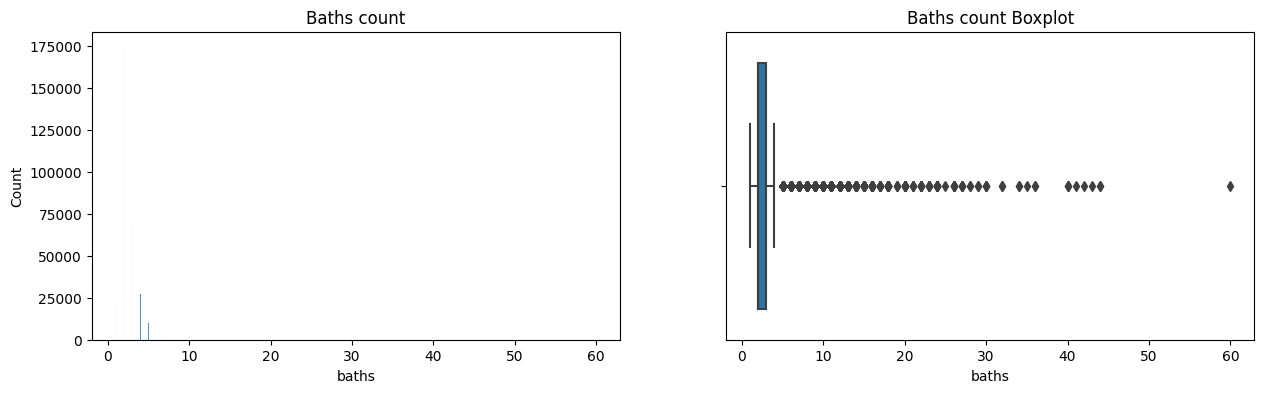

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data, x='baths', ax=axes[0]);
histplot.set_title('Baths count');
boxplot = sns.boxplot(data=data, x='baths', ax=axes[1]);
boxplot.set_title('Baths count Boxplot');

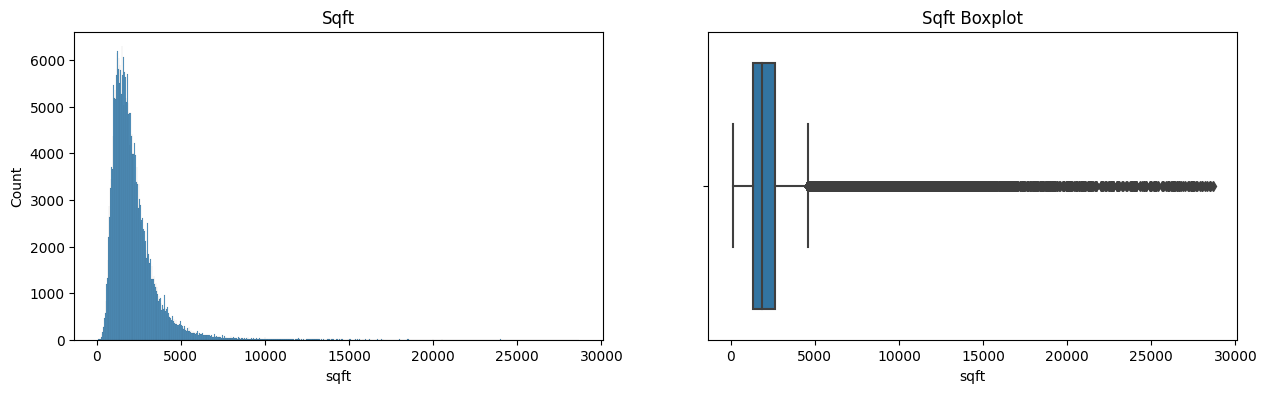

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data, x='sqft', ax=axes[0]);
histplot.set_title('Sqft');
boxplot = sns.boxplot(data=data, x='sqft', ax=axes[1]);
boxplot.set_title('Sqft Boxplot');

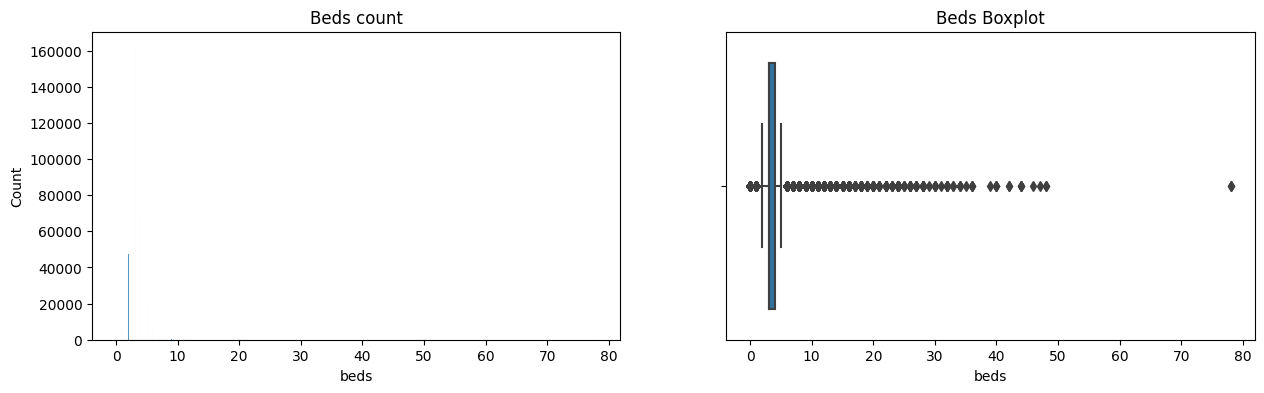

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data, x='beds', ax=axes[0]);
histplot.set_title('Beds count');
boxplot = sns.boxplot(data=data, x='beds', ax=axes[1]);
boxplot.set_title('Beds Boxplot');

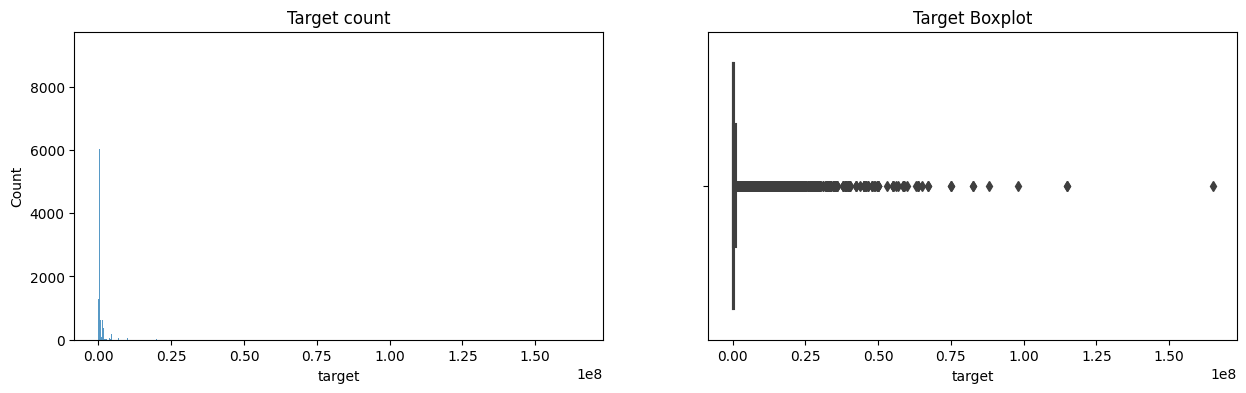

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data, x='target', ax=axes[0]);
histplot.set_title('Target count');
boxplot = sns.boxplot(data=data, x='target', ax=axes[1]);
boxplot.set_title('Target Boxplot');

## 3. Очистка данных от выбросов методом z-отклонений

In [63]:
def outliers_z_score_mod(data, feature, log_scale=False, left=3, right=3):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [64]:
outliers, data = outliers_z_score_mod(data, 'sqft', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {data.shape[0]}')

Число выбросов по методу z-отклонения: 2281
Результирующее число записей: 312807


In [65]:
outliers, data = outliers_z_score_mod(data, 'baths', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {data.shape[0]}')

Число выбросов по методу z-отклонения: 3699
Результирующее число записей: 309108


In [66]:
outliers, data = outliers_z_score_mod(data, 'beds', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {data.shape[0]}')

Число выбросов по методу z-отклонения: 2307
Результирующее число записей: 306801


In [67]:
outliers, data = outliers_z_score_mod(data, 'target', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {data.shape[0]}')

Число выбросов по методу z-отклонения: 3679
Результирующее число записей: 303122


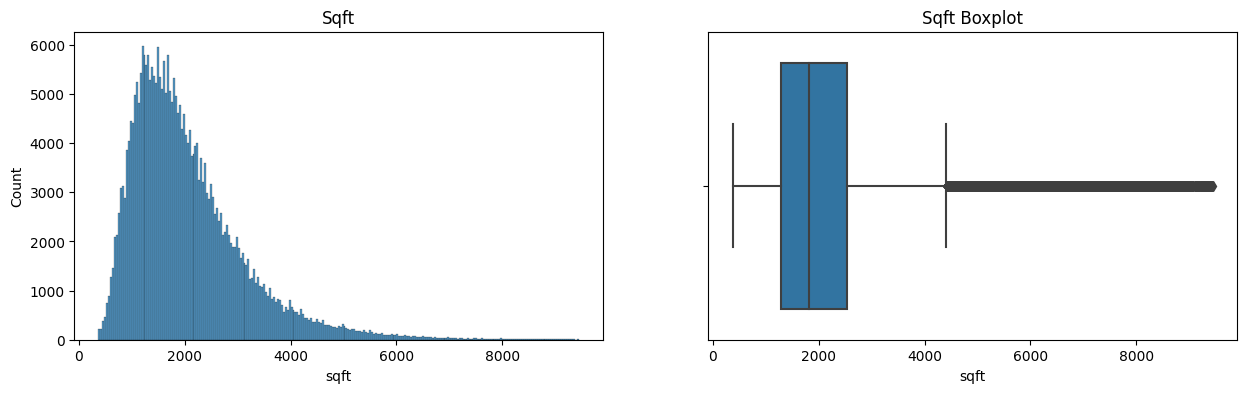

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data, x='sqft', ax=axes[0]);
histplot.set_title('Sqft');
boxplot = sns.boxplot(data=data, x='sqft', ax=axes[1]);
boxplot.set_title('Sqft Boxplot');

In [69]:
display('Number of duplicates: {}'.format(data.duplicated().sum()))

'Number of duplicates: 15241'

In [70]:
# удалим дубликаты
data = data.drop_duplicates().reset_index(drop=True)

display('Shape of data: {}'.format(data.shape))

'Shape of data: (287881, 11)'

## 4. Проверка на мультиколлениарность и кодирование признаков

<Axes: >

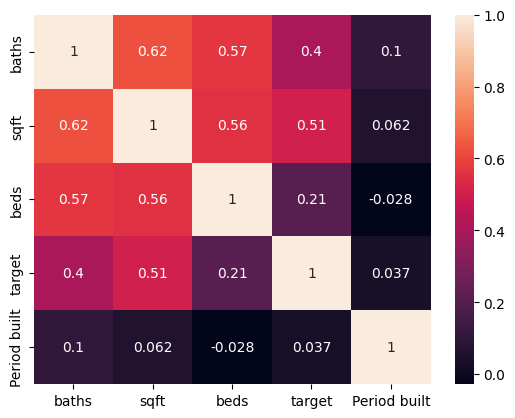

In [71]:
# проверим числовые признаки на мультиколлениарность
sns.heatmap(data.corr(numeric_only=True), annot=True)

Коллинеарности выше 70% не обнаружено.

Закодируем признаки status, propertyType однократным кодированием, а state - бинарным. 

In [72]:
data = pd.get_dummies(data, columns=['status','propertyType']) #однократное кодирование

#бинарное кодирование
bin_encoder = ce.BinaryEncoder(cols=['state']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['state'])
data = pd.concat([data, type_bin], axis=1)

data.head()

,baths,city,sqft,zipcode,beds,state,target,Year built,Period built,status_activated,...,propertyType_single detached,propertyType_single family,propertyType_townhouse,propertyType_traditional,state_0,state_1,state_2,state_3,state_4,state_5
0,3.0,Southern Pines,2900.0,28387,4.0,NC,418000.0,2019,5,True,...,False,True,False,False,0,0,0,0,0,1
1,3.0,Spokane Valley,1947.0,99216,3.0,WA,310000.0,2019,5,True,...,False,True,False,False,0,0,0,0,1,0
2,2.0,Los Angeles,3000.0,90049,3.0,CA,2895000.0,1961,4,True,...,False,True,False,False,0,0,0,0,1,1
3,2.0,Philadelphia,897.0,19145,2.0,PA,209000.0,1920,3,True,...,False,False,True,False,0,0,0,1,0,0
4,2.0,POINCIANA,1507.0,34759,3.0,FL,181500.0,2006,5,True,...,False,False,False,False,0,0,0,1,0,1


In [73]:
# удаляем стобцы типа object

cols_del = data.select_dtypes('object').columns.to_list()

data = data.drop(cols_del, axis=1)

display('Количество признаков в данных: {}'.format(data.shape[1]))
display('Количество наблюдений: {}'.format(data.shape[0]))

'Количество признаков в данных: 36'

'Количество наблюдений: 287881'

## 5. Построение модели линейной регрессии для предсказания стоимости объектов недвижимости

In [74]:
y = data['target']
X = data.drop(['target'], axis=1)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [77]:
scaler = preprocessing.MinMaxScaler() #создаем объект для нормализации
scaler.fit(X_train) #рассчитываем параметры нормализации (fit) на тренировочной выборке

#производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Создаем объект для генерации полиномиальных признаков степени 2
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
#Вычисляем параметры генерации - результирующее количество признак
poly.fit(X_train_scaled)
#Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

In [78]:
#Создаем объект класса линейная регрессия с L1-регуляризацией
#Выставляем параметр alpha используйте значение по умолчанию, параметр max_iter установите в значение 2000
lasso_lr = linear_model.Lasso(max_iter=2000)
#Обучаем модель предсказывать логарифм целевого признака
lasso_lr.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для каждой из выборок
#Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
y_train_pred = lasso_lr.predict(X_train_scaled_poly)
y_test_pred = lasso_lr.predict(X_test_scaled_poly)

print('Test R2 score:{:.3f}'.format(metrics.r2_score(y_test, y_test_pred)))
print('Train R2 score: {:.3F}'.format(metrics.r2_score(y_train, y_train_pred)))


Test R2 score:0.506
Train R2 score: 0.497


In [79]:
# Создаем модель случайного леса из 10 деревьев с максимальной глубиной 10 для каждого дерева 
regr = RandomForestRegressor(max_depth=10, n_estimators=10, random_state=42)
# Обучаем модель
regr.fit(X_train, y_train)

# Формируем предсказания каждой из моделей
y_test_pred_for = regr.predict(X_test)
y_train_pred_for = regr.predict(X_train)

print('Test R2 score:{:.3f}'.format(metrics.r2_score(y_test, y_test_pred_for)))
print('Train R2 score: {:.3F}'.format(metrics.r2_score(y_train, y_train_pred_for)))


Test R2 score:0.539
Train R2 score: 0.571


In [80]:
# Создаем модель случайного леса из 10 деревьев с максимальной глубиной 10 для каждого дерева 
regr1 = RandomForestRegressor(max_depth=10, n_estimators=10, random_state=42)
# Обучаем модель
regr1.fit(X_train_scaled_poly, y_train)

# Формируем предсказания
y_train_pred1 = regr1.predict(X_train_scaled_poly)
y_test_pred1 = regr1.predict(X_test_scaled_poly)

print('Test R2 score:{:.3f}'.format(metrics.r2_score(y_test, y_test_pred1)))
print('Train R2 score: {:.3F}'.format(metrics.r2_score(y_train, y_train_pred1)))
 

Test R2 score:0.560
Train R2 score: 0.600


In [81]:
import pickle

# Сохранение выбранной обученной модели в файл pickle
with open('model/dp_model.pkl', 'wb') as output:
    pickle.dump(regr1, output)